# MOVIELENS大作业

In [10]:
!pip install numpy
!pip install pandas
!pip install jupyter
!pip install matplotlib
!pip install scikit-learn
!pip install Pillow
!pip install opencv-python
!pip install img2vec_pytorch
!pip install torch
!pip install torchvision

  Using cached jupyter-1.0.0-py2.py3-none-any.whl.metadata (995 bytes)
  Using cached qtconsole-5.5.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached ipywidgets-8.1.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.10-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.10-py3-none-any.whl.metadata (4.1 kB)
  Using cached bleach-6.1.0-py3-none-any.whl.metadata (30 kB)
  Using cached jupyterlab_pygments-0.3.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached mistune-3.0.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached pandocfilters-1.5.1-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached anyio-4.3.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached jupyter

In [11]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Reading ratings file
ratings = pd.read_csv('./ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('./users.csv', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('./movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

# Reading movies info file
movies_info = pd.read_csv('./info.csv',  encoding='latin-1', usecols=['id', 'name', 'genre','intro','directors','starts', 'release_time'])
movies_info.rename(columns ={ 'id':'movie_id', 'starts': 'stars'}, inplace = True)

In [12]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [13]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


In [14]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
movies_info.head()

,movie_id,name,genre,release_time,intro,directors,stars
0,1,Toy Story (1995),Animation|Adventure|Comedy,22 November 1995 (USA),A cowboy doll is profoundly threatened and jea...,John Lasseter,Tom Hanks|Tim Allen|Don Rickles
1,2,Jumanji (1995),Adventure|Comedy|Family,15 December 1995 (USA),When two kids find and play a magical board ga...,Joe Johnston,Robin Williams|Kirsten Dunst|Bonnie Hunt
2,3,Grumpier Old Men (1995),Comedy|Romance,22 December 1995 (USA),John and Max resolve to save their beloved bai...,Howard Deutch,Walter Matthau|Jack Lemmon|Ann-Margret
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,22 December 1995 (USA),"Based on Terry McMillan's novel, this film fol...",Forest Whitaker,Whitney Houston|Angela Bassett|Loretta Devine
4,5,Father of the Bride Part II (1995),Comedy|Family|Romance,8 December 1995 (USA),George Banks must deal not only with the pregn...,Charles Shyer,Steve Martin|Diane Keaton|Martin Short


## 一、传统偏好发现

### 男女偏好分析

In [16]:
# 筛选出观影人次大于300的电影
popular = ratings['movie_id'].value_counts()
popular = popular[popular > 300]
popular = popular.rename('count')
popular = popular.rename_axis('movie_id')
print("Popular:")
display(popular)

Popular:


movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
2404     301
1845     301
1012     301
535      301
2363     301
Name: count, Length: 1053, dtype: int64

In [17]:
import matplotlib.pyplot as plt

# 如何衡量偏好程度？看过某部电影的男性/女性观众对该部电影的平均打分显然是最重要的衡量依据，
# 但我们需要注意到，受“偏好”程度用男性/女性观众对该部电影的平均打分之差来衡量要比用各自的绝对值来衡量更合理。
# 但是同时，该电影的观影人次也应当有加权，比如总观影人次非常多的电影如果还呈现出明显的性别打分差异，
# 那么更能说明这部电影是明显的性别偏好电影，因为打分随机性等可能导致非内在的男女打分差异的因素影响会较弱，性别差异结果的“信度”就更高。
# 不过这一项只是辅助指标，不应成为影响最终评价函数的最主要因素。故最终我选择用 " * ln(总观影人次) " 的方式。
# 因此，我最终定义的评价函数是 " (男性观众平均打分 - 女性观众平均打分) * ln(总观影人次) " 。

# 我这里没有使用每部电影的“男性观影人次”和“女性观影人次”这两个指标，
# 是因为这会涉及男/女性观众人数不一致等问题，会带来麻烦，纵然进行归一化等操作也很难不使评价结果失真。

gender_users = pd.merge(users, ratings, on='user_id', how='outer')
gender_users = gender_users[gender_users['movie_id'].isin(popular.index)] # 只保留popular的电影

female_users = gender_users[gender_users['gender'] == 'F']
male_users = gender_users[gender_users['gender'] == 'M']

# 计算平均打分
female_mean_rating = female_users.groupby('movie_id')['rating'].mean()
male_mean_rating = male_users.groupby('movie_id')['rating'].mean()
print("Female mean rating:")
display(female_mean_rating)
print("\nMale mean rating:")
display(male_mean_rating)

# 计算评价函数
score = male_mean_rating - female_mean_rating
score = pd.merge(score, popular, on='movie_id', how='outer') # 加入总观影人次这一列
score['score'] = score['rating'] * np.log(score['count']) # score['score']这一列为评价函数
print("\nScore:")
display(score)

Female mean rating:


movie_id
1       4.187817
2       3.278409
3       3.073529
6       3.682171
7       3.588235
          ...   
3916    4.093458
3927    3.535714
3948    3.619048
3949    3.950000
3952    3.761905
Name: rating, Length: 1053, dtype: float64


Male mean rating:


movie_id
1       4.130552
2       3.175238
3       2.994152
6       3.909988
7       3.267717
          ...   
3916    3.869697
3927    3.589041
3948    3.641838
3949    4.174107
3952    3.787986
Name: rating, Length: 1053, dtype: float64


Score:


,rating,count,score
movie_id,,,
1,-0.057265,2077,-0.437432
2,-0.103171,701,-0.676029
3,-0.079377,478,-0.489727
6,0.227817,940,1.559609
7,-0.320519,458,-1.963777
...,...,...,...
3916,-0.223761,437,-1.360452
3927,0.053327,348,0.312079
3948,0.022791,862,0.154048


In [20]:
# 筛出前20名和后20名的电影，分别作为男/女性偏好的电影
male_preference = score.nlargest(20, 'score').reset_index()
female_preference = score.nsmallest(20, 'score').reset_index()
female_preference['score'] = - female_preference['score']
print(male_preference)

    movie_id    rating  count     score
0       1201  0.726351    822  4.875077
1        231  0.638608    660  4.145998
2       3552  0.573602    967  3.943051
3       3760  0.676359    305  3.868985
4       1261  0.611985    548  3.859348
5       3421  0.538286   1207  3.819621
6        784  0.613787    385  3.654026
7       3062  0.619682    352  3.633586
8       1997  0.529605    885  3.593678
9       2410  0.581801    401  3.487291
10        70  0.496844    914  3.387397
11      1089  0.444642   1259  3.173888
12      3740  0.497078    584  3.166338
13      3681  0.544704    325  3.150475
14      3688  0.539489    339  3.143061
15       785  0.465173    765  3.088688
16      1405  0.498054    475  3.069664
17      2409  0.501515    445  3.058274
18      2791  0.407854   1731  3.041143
19      2700  0.424206   1269  3.031368


In [19]:
# 详细展示这些选出的电影的信息
print("男性最偏好的20部电影：")
male_preference_detail = pd.merge(male_preference, movies, on='movie_id', how='inner')
male_preference_detail = male_preference_detail.drop(['rating', 'count', 'score', 'movie_id'], axis=1) # 去除无需展示的列
male_preference_detail['ranking'] = male_preference_detail.index.to_series().apply(lambda x: x+1)
male_preference_detail = male_preference_detail.set_index('ranking') # 增加“排名”这一列，并将其设为index
display(male_preference_detail)

print("\n女性最偏好的20部电影：")
female_preference_detail = pd.merge(female_preference, movies, on='movie_id', how='inner')
female_preference_detail = female_preference_detail.drop(['rating', 'count', 'score', 'movie_id'], axis=1) # 去除无需展示的列
female_preference_detail['ranking'] = female_preference_detail.index.to_series().apply(lambda x: x+1)
female_preference_detail = female_preference_detail.set_index('ranking') # 增加“排名”这一列，并将其设为index
display(female_preference_detail)

男性最偏好的20部电影：


,title,genres
ranking,,
1,"Good, The Bad and The Ugly, The (1966)",Action|Western
2,Dumb & Dumber (1994),Comedy
3,Caddyshack (1980),Comedy
4,"Kentucky Fried Movie, The (1977)",Comedy
5,Evil Dead II (Dead By Dawn) (1987),Action|Adventure|Comedy|Horror
6,Animal House (1978),Comedy
7,"Cable Guy, The (1996)",Comedy
8,"Longest Day, The (1962)",Action|Drama|War
9,"Exorcist, The (1973)",Horror



女性最偏好的20部电影：


,title,genres
ranking,,
1,Dirty Dancing (1987),Musical|Romance
2,Grease (1978),Comedy|Musical|Romance
3,Jumpin' Jack Flash (1986),Action|Comedy|Romance|Thriller
4,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi
5,Mary Poppins (1964),Children's|Comedy|Musical
6,Steel Magnolias (1989),Drama
7,Gone with the Wind (1939),Drama|Romance|War
8,"Sound of Music, The (1965)",Musical
9,"Color Purple, The (1985)",Drama


In [6]:
# 其他的流行统计量
# 𝑅𝑎=𝑊𝑅+(1−𝑊)𝑅0
# 𝑅𝑎=平均(贝叶斯)评级
# 𝑅=个体评分：此个体的平均评分。
# 𝑅0=先验评级：全局平均评级，适用于数据库中的所有项目。
# 𝑊=加权因子：如果此项投票较少，则应趋于0，如果投票较多，则应趋于1。
# 𝑊=𝑚𝑎𝑥(𝛼*𝑛/𝑁𝑎𝑣,1)，n为该电影的观影人次，𝑁𝑎𝑣为所有电影的平均观影人次，𝛼为0.5到1之间的某个数

#重新计算popular
R=ratings.groupby('movie_id')['rating'].mean()
N=ratings.groupby('movie_id')['rating'].count()
popular=pd.DataFrame({'rating':R,'count':N})
W=popular['count'].apply(lambda x: max(0.5*x/popular['count'].mean(),1))
popular['rating']=W*popular['rating']+(1-W)*popular['rating'].mean()
popular=popular.sort_values(by='rating',ascending=False)
popular_percentile=popular['rating'].quantile(0.9)
popular=popular[popular['rating']>=popular_percentile]
print(popular)

#剩下的步骤题目没要求，就和上面用一样的，虽然也可以优化挺多，但是也足够了
gender_users = pd.merge(users, ratings, on='user_id', how='outer')
gender_users = gender_users[gender_users['movie_id'].isin(popular.index)] # 只保留popular的电影

female_users = gender_users[gender_users['gender'] == 'F']
male_users = gender_users[gender_users['gender'] == 'M']

# 计算平均打分
female_mean_rating = female_users.groupby('movie_id')['rating'].mean()
male_mean_rating = male_users.groupby('movie_id')['rating'].mean()
print("Female mean rating:")
display(female_mean_rating)
print("\nMale mean rating:")
display(male_mean_rating)

# 计算评价函数
score = male_mean_rating - female_mean_rating
score = pd.merge(score, popular, on='movie_id', how='outer') # 加入总观影人次这一列
score['score'] = score['rating_x'] * score['rating_y'] # score['score']这一列为评价函数
print("\nScore:")
display(score)

# 筛出前20名和后20名的电影，分别作为男/女性偏好的电影
male_preference = score.nlargest(20, 'score').reset_index()
female_preference = score.nsmallest(20, 'score').reset_index()
female_preference['score'] = - female_preference['score']

# 详细展示这些选出的电影的信息
print("男性最偏好的20部电影：")
male_preference_detail = pd.merge(male_preference, movies, on='movie_id', how='inner')
male_preference_detail = male_preference_detail.drop(['rating_x', 'rating_y', 'score', 'movie_id'], axis=1) # 去除无需展示的列
male_preference_detail['ranking'] = male_preference_detail.index.to_series().apply(lambda x: x+1)
male_preference_detail = male_preference_detail.set_index('ranking') # 增加“排名”这一列，并将其设为index
display(male_preference_detail)

print("\n女性最偏好的20部电影：")
female_preference_detail = pd.merge(female_preference, movies, on='movie_id', how='inner')
female_preference_detail = female_preference_detail.drop(['rating_x', 'rating_y', 'score', 'movie_id'], axis=1) # 去除无需展示的列
female_preference_detail['ranking'] = female_preference_detail.index.to_series().apply(lambda x: x+1)
female_preference_detail = female_preference_detail.set_index('ranking') # 增加“排名”这一列，并将其设为index
display(female_preference_detail)

             rating  count
movie_id                  
2858      10.088146   3428
260        9.970312   2991
1196       9.077795   2990
1198       9.008716   2514
318        8.667024   2227
...             ...    ...
1280       4.173285    277
955        4.169492    413
2726       4.169231    130
2948       4.168559    771
3424       4.167839    781

[371 rows x 2 columns]
Female mean rating:


movie_id
1       4.187817
6       3.682171
11      3.923483
17      4.233333
21      3.597902
          ...   
3801    4.306122
3881    5.000000
3888    5.000000
3897    4.220217
3911    4.056075
Name: rating, Length: 361, dtype: float64


Male mean rating:


movie_id
1       4.130552
6       3.909988
11      3.718654
17      3.819277
21      3.630841
          ...   
3793    3.851702
3801    4.206667
3888    4.000000
3897    4.228731
3911    4.081264
Name: rating, Length: 367, dtype: float64


Score:


,rating_x,rating_y,count,score
movie_id,,,,
1,-0.057265,6.732588,2077,-0.385545
6,0.227817,4.353130,940,0.991718
11,-0.204828,4.300855,1033,-0.880937
17,-0.414056,4.458884,835,-1.846229
21,0.032939,4.206071,1356,0.138544
...,...,...,...,...
3801,-0.099456,4.231156,199,-0.420813
3881,NaN,5.000000,1,NaN
3888,-1.000000,4.500000,2,-4.500000


男性最偏好的20部电影：


,count,title,genres
ranking,,,
1,10,Time of the Gypsies (Dom za vesanje) (1989),Drama
2,27,For All Mankind (1989),Documentary
3,2,Dangerous Game (1993),Drama
4,2,"Bells, The (1926)",Crime|Drama
5,822,"Good, The Bad and The Ugly, The (1966)",Action|Western
6,8,Window to Paris (1994),Comedy
7,1207,Animal House (1978),Comedy
8,1692,"Godfather: Part II, The (1974)",Action|Crime|Drama
9,967,Caddyshack (1980),Comedy



女性最偏好的20部电影：


,count,title,genres
ranking,,,
1,2,Skipped Parts (2000),Drama|Romance
2,14,Hearts and Minds (1996),Drama
3,23,Aparajito (1956),Drama
4,11,Firelight (1997),Drama
5,56,"World of Apu, The (Apur Sansar) (1959)",Drama
6,1156,Gone with the Wind (1939),Drama|Romance|War
7,1011,Mary Poppins (1964),Children's|Comedy|Musical
8,882,"Sound of Music, The (1965)",Musical
9,835,Sense and Sensibility (1995),Drama|Romance


### 不同类型电影的男女偏好可视化

#### 数据预处理

In [7]:
data = pd.merge(ratings, users, how='outer')
data = pd.merge(data, movies, how='outer')
data

,user_id,movie_id,rating,timestamp,gender,zipcode,age_desc,occ_desc,title,genres
0,1.0,1193,5.0,978300760.0,F,48067,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,M,70072,56+,self-employed,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,M,32793,25-34,programmer,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,M,22903,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,M,95350,50-55,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000381,NaN,3650,NaN,NaN,NaN,NaN,NaN,NaN,Anguish (Angustia) (1986),Horror
1000382,NaN,3750,NaN,NaN,NaN,NaN,NaN,NaN,Boricua's Bond (2000),Drama
1000383,NaN,3829,NaN,NaN,NaN,NaN,NaN,NaN,Mad About Mambo (2000),Comedy|Romance
1000384,NaN,3856,NaN,NaN,NaN,NaN,NaN,NaN,Autumn Heart (1999),Drama


In [8]:
data_male = data[data.gender=='M']
data_female = data[data.gender=='F']
female_count = data_female.shape[0]
male_count = data_male.shape[0]
data_male.shape, data_female.shape

((753769, 10), (246440, 10))

#### 将genres进行split操作，构建描述矩阵

In [9]:
# 看看总共有多少个风格
genre_list = []
for i in movies.genres:
    genre = i.split(sep='|')
    genre_list += genre
genre_list = list(set(genre_list))
genre_list

['Action',
 'Sci-Fi',
 'Western',
 'Adventure',
 'Documentary',
 'Comedy',
 'Crime',
 'Fantasy',
 'Horror',
 'Romance',
 'Musical',
 'Animation',
 'War',
 'Mystery',
 'Film-Noir',
 "Children's",
 'Drama',
 'Thriller']

In [10]:
# 统计每个电影的风格
num_movies = movies.shape[0]
for genre in genre_list:
    movies[genre] = 0
for i in movies.index:
    genre = movies.loc[i].genres.split(sep='|')
    for j in genre:
        movies[j][i] = 1
movies

,movie_id,title,genres,Action,Sci-Fi,Western,Adventure,Documentary,Comedy,Crime,...,Horror,Romance,Musical,Animation,War,Mystery,Film-Noir,Children's,Drama,Thriller
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3880,3950,Tigerland (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3881,3951,Two Family House (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
data_2 = pd.merge(ratings, users, how='outer')
data_2 = pd.merge(data, movies, how='outer')
data_2.shape

(1000386, 28)

In [12]:
data_2_male = data_2[data_2.gender=='M']
data_2_female = data_2[data_2.gender=='F']

data_2_male.head()

,user_id,movie_id,rating,timestamp,gender,zipcode,age_desc,occ_desc,title,genres,...,Horror,Romance,Musical,Animation,War,Mystery,Film-Noir,Children's,Drama,Thriller
1,2.0,1193,5.0,978298413.0,M,70072,56+,self-employed,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,1,0
2,12.0,1193,4.0,978220179.0,M,32793,25-34,programmer,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,1,0
3,15.0,1193,4.0,978199279.0,M,22903,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,1,0
4,17.0,1193,5.0,978158471.0,M,95350,50-55,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,1,0
6,19.0,1193,5.0,982730936.0,M,48073,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,1,0


In [13]:
# 初始化一个用于对比男女不同风格差异的表格
df_2 = pd.DataFrame(np.zeros((len(genre_list), 8)), index=genre_list, columns=[['Male', 'Male', 'Male', 'Male', 'Female', 'Female', 'Female', 'Female'], ['mean', 'std', 'count', 'portion', 'mean', 'std', 'count', 'portion']])
df_2

Male                    Female                   
            mean  std count portion   mean  std count portion
Action       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Sci-Fi       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Western      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Adventure    0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Documentary  0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Comedy       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Crime        0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Fantasy      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Horror       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Romance      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Musical      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Animation    0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
War          0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Mystery      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Film-Noir    0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Children's   0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Drama        0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Thriller     0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0

In [14]:
# 收集每个风格的均值，分风格将数据归一化；同时收集每个genre中男性和女性评分数据
genre_rating_male = []
genre_rating_female = []
for i in genre_list:
    data_2_genre_m = data_2_male[data_2_male[i]==1]
    m_mean = data_2_genre_m.rating.mean()
    m_std = data_2_genre_m.rating.std()
    data_2_genre_m.rating = (data_2_genre_m.rating - m_mean) / m_std
    df_2.loc[i, ('Male', 'mean')] = m_mean
    df_2.loc[i, ('Male', 'std')] = m_std
    df_2.loc[i, ('Male', 'count')] = data_2_genre_m.shape[0]
    df_2.loc[i, ('Male', 'portion')] = df_2.loc[i, ('Male', 'count')] / male_count
    genre_rating_male.append(data_2_genre_m.rating.to_list())


    data_2_genre_f =data_2_female[data_2_female[i]==1]
    f_mean=data_2_genre_f.rating.mean()
    f_std=data_2_genre_f.rating.std()
    data_2_genre_f.rating=(data_2_genre_f.rating-f_mean)/f_std
    df_2.loc[i,('Female','mean')]=f_mean
    df_2.loc[i,('Female','std')]=f_std
    df_2.loc[i,('Female','count')]=data_2_genre_f.shape[0]
    df_2.loc[i,('Female','portion')]=df_2.loc[i,('Female','count')]/female_count
    genre_rating_female.append(data_2_genre_f.rating.to_list())


df_2

Male                                  Female            \
                 mean       std     count   portion      mean       std   
Action       3.491386  1.131881  211807.0  0.280997  3.490252  1.140833   
Sci-Fi       3.469952  1.152751  129894.0  0.172326  3.450255  1.178171   
Western      3.655120  1.096121   17206.0  0.022827  3.551913  1.114281   
Adventure    3.468125  1.129543  106621.0  0.141450  3.512879  1.128469   
Documentary  3.928811  1.033753    5970.0  0.007920  3.946392  1.031336   
Comedy       3.503667  1.122733  260309.0  0.345343  3.571938  1.113762   
Crime        3.713720  1.073237   63099.0  0.083711  3.689332  1.094665   
Fantasy      3.426603  1.134127   27583.0  0.036593  3.513076  1.127727   
Horror       3.217891  1.218729   61751.0  0.081923  3.202870  1.253795   
Romance      3.573262  1.069230   97226.0  0.128986  3.673579  1.058839   
Musical      3.596332  1.117510   28028.0  0.037184  3.809108  1.051752   
Animation    3.661335  1.085677   31072.0  0.041222  3.744702  1.070565   
War          3.893375  1.065102   54434.0  0.072216  3.893138  1.066051   
Mystery      3.662009  1.084549   30202.0  0.040068  3.686548  1.093193   
Film-Noir    4.092254  0.920489   14059.0  0.018652  4.018087  0.970234   
Children's   3.358961  1.171177   50869.0  0.067486  3.572548  1.121722   
Drama        3.766589  1.045872  256376.0  0.340125  3.765662  1.045558   
Thriller     3.569685  1.099485  149372.0  0.198167  3.573360  1.132786   

                                
               count   portion  
Action       45650.0  0.185238  
Sci-Fi       27400.0  0.111183  
Western       3477.0  0.014109  
Adventure    27332.0  0.110907  
Documentary   1940.0  0.007872  
Comedy       96271.0  0.390647  
Crime        16442.0  0.066718  
Fantasy       8718.0  0.035376  
Horror       14635.0  0.059386  
Romance      50297.0  0.204094  
Musical      13505.0  0.054800  
Animation    12221.0  0.049590  
War          14093.0  0.057186  
Mystery       9976.0  0.040480  
Film-Noir     4202.0  0.017051  
Children's   21317.0  0.086500  
Drama        98153.0  0.398284  
Thriller     40308.0  0.163561

### 可视化结果展示

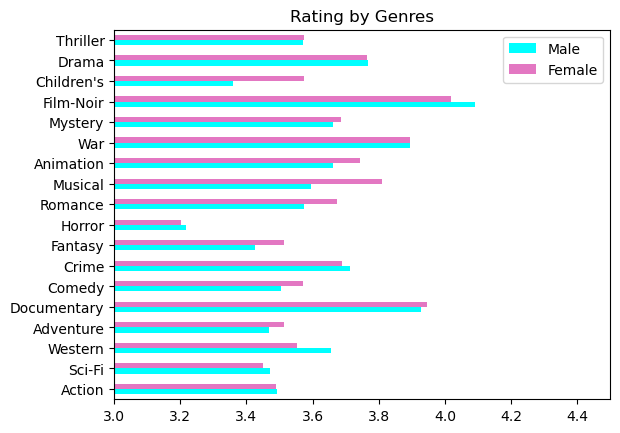

In [15]:
import matplotlib.pyplot as plt
df_2.plot.barh(y=[('Male', 'mean'), ('Female', 'mean')], color=['cyan', 'tab:pink'])
plt.title('Rating by Genres')
plt.xlim(3, 4.5)
plt.legend(['Male', 'Female'])
plt.savefig('ratings by genres.png')

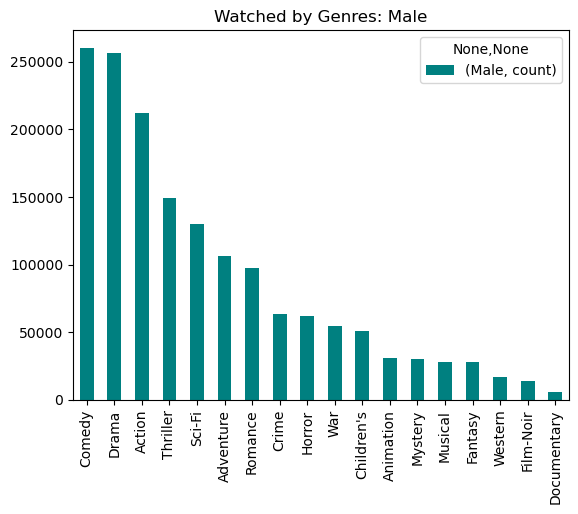

In [16]:
df_2.sort_values(by=('Male', 'count'), inplace=True, ascending=False)
df_2.plot.bar(y=('Male', 'count'), color=(0, 128/255, 128/255))
plt.title('Watched by Genres: Male')
plt.savefig('counts by genres: male.png')

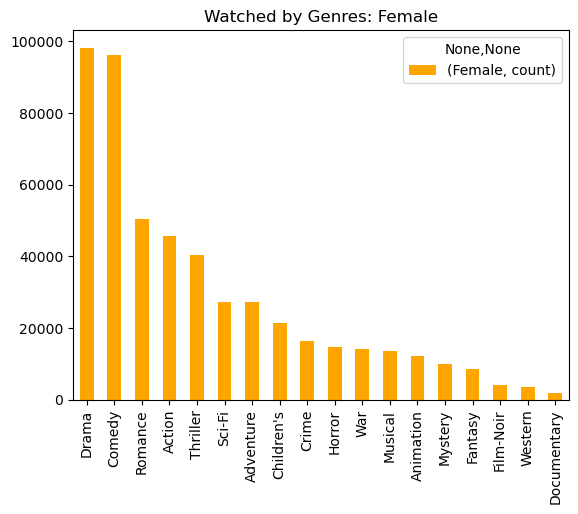

In [17]:
df_2.sort_values(by=('Female', 'count'), inplace=True, ascending=False)
df_2.plot.bar(y=('Female', 'count'), color='orange')
plt.title('Watched by Genres: Female')
plt.savefig('counts by genres: female.png')

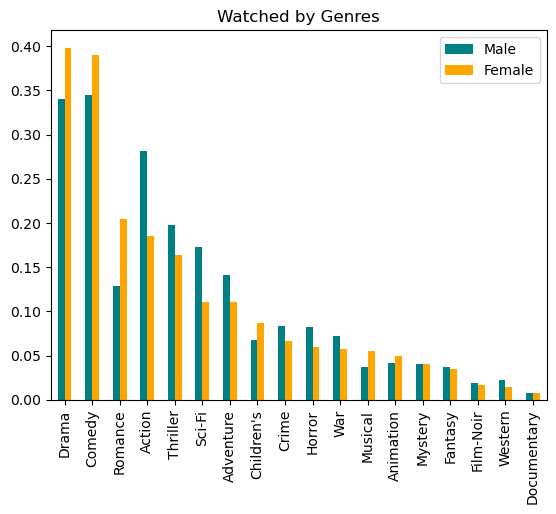

In [18]:
df_2.plot.bar(y=[('Male', 'portion'), ('Female', 'portion')], color=[(0, 128/255, 128/255), 'orange'])
plt.title('Watched by Genres')
plt.legend(['Male', 'Female'])
plt.savefig('counts by genres.png')

## 二、用户对电影的打分预测

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import datetime
from sklearn.decomposition import TruncatedSVD



### 示例：基于SVD对用户电影评分数据进行协同过滤预测

In [20]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
rating_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating',)
rating_matrix = rating_matrix.fillna(0)
train_matrix = rating_matrix.copy()
for i in range(len(test)):
    train_matrix.loc[test.iloc[i]['user_id'], test.iloc[i]['movie_id']] = 0
 
# SVD分解
svd_k = 100
svd = TruncatedSVD(n_components=svd_k)
user_vectors = svd.fit_transform(train_matrix)
item_vectors = svd.components_.T

# 预测评分
predicted_ratings = np.dot(user_vectors, item_vectors.T)
predicted_ratings = pd.DataFrame(predicted_ratings, index=rating_matrix.index, columns=rating_matrix.columns)

mse_score = 0
for i in range(len(test)):
    mse_score += (max(int(predicted_ratings.loc[test.iloc[i]['user_id'], test.iloc[i]['movie_id']]),0) - test.iloc[i]['rating']) ** 2
print('MSE:', mse_score / test.shape[0])

MSE: 10.49404625028744


### 请你不要局限于对评分矩阵做SVD分解，尝试加入用户类型及偏好进行优化。另：加入电影信息获得好的效果可以加5分。

In [21]:
# 评分参考
mse_score = 0
def grade(score):
    if score >= 2:
        return 0
    elif score >= 1:
        return 30
    else:
        return 40

## 三、电影海报聚类分析

In [22]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from img2vec_pytorch import Img2Vec



# 文件夹路径
folder_path = "./poster"

# 初始化特征列表
features = []

img2vec_model = Img2Vec()
# 遍历文件夹中的每个海报图像
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # 读取图像
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        # 提取颜色直方图和灰度直方图特征
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        vector = img2vec_model.get_vec(image)

        feature_vector = vector

        # 添加图像文件前缀（电影ID）和特征向量到特征列表中
        features.append([filename.split('.')[0], feature_vector])

# 将特征列表转换为DataFrame
columns = ['movie_id', 'features']
df = pd.DataFrame(features, columns=columns)

# 输出带有电影ID和特征向量的DataFrame
print("DataFrame with Movie ID and Features:")
print(df.head())

DataFrame with Movie ID and Features:
  movie_id                                           features
0     1430  [0.4136729, 2.1776845, 0.85309166, 1.035356, 1...
1     3391  [0.80747545, 1.5654334, 0.93173194, 0.01969247...
2     2618  [0.18467441, 0.71609473, 0.17207062, 0.3224041...
3      472  [1.689616, 0.74003905, 0.3010845, 0.17777342, ...
4     2810  [0.23077062, 0.3200877, 0.010672037, 1.046026,...


### 无监督聚类结果的可视化

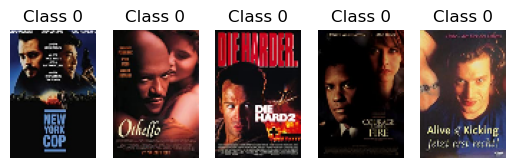

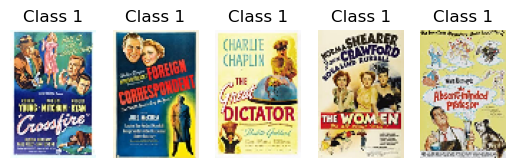

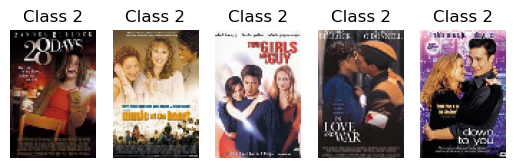

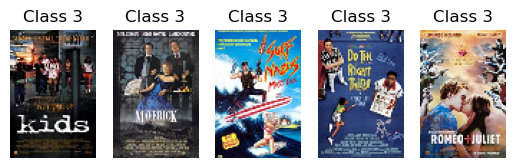

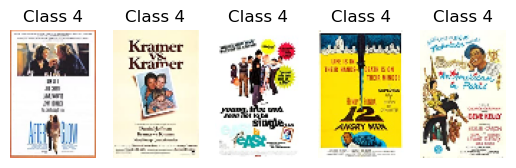

In [25]:
import matplotlib.pyplot as plt
# 打印每个类别的代表性图像
for i, indices in enumerate(representative_images):
    # 设置图像的大小
    for j, index in enumerate(indices):
        # 读取代表性图像
        representative_image_path = os.path.join(folder_path, os.listdir(folder_path)[index])
        representative_image = cv2.imread(representative_image_path)
        representative_image = cv2.resize(representative_image, (60, 90))
        # 绘制图像
        plt.subplot(1, 5, j+1)
        plt.imshow(cv2.cvtColor(representative_image, cv2.COLOR_BGR2RGB))
        plt.title("Class {}".format(i))
        plt.axis("off")

    plt.show()


### 有监督聚类

In [26]:
import pandas as pd

# 读取CSV文件
movies_df = pd.read_csv("./movies.csv")

# 提取genre信息
genres = movies_df['genres']
# 初始化genre的字典
genre_dict = {}

# 遍历每个电影的genre信息
for genre_string in genres:
    # 将genre字符串按照"|"分割成列表
    genre_list = genre_string.split("|")
    # 遍历列表中的每个genre
    for genre in genre_list:
        # 将genre添加到字典中，如果已存在则不重复添加
        if genre not in genre_dict:
            genre_dict[genre] = len(genre_dict)

# 输出genre字典
print("Genre Dictionary:")
print(genre_dict)

Genre Dictionary:
{'Animation': 0, "Children's": 1, 'Comedy': 2, 'Adventure': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'Sci-Fi': 11, 'Documentary': 12, 'War': 13, 'Musical': 14, 'Mystery': 15, 'Film-Noir': 16, 'Western': 17}


In [27]:

# 将genre信息转换为向量形式
genre_vectors = []

# 遍历每个电影的genre信息
for genre_string in genres:
    # 将genre字符串按照"|"分割成列表
    genre_list = genre_string.split("|")
    # 初始化genre向量
    genre_vector = [0] * len(genre_dict)
    # 根据genre列表设置向量中对应的位置为1
    for genre in genre_list:
        genre_vector[genre_dict[genre]] = 1
    # 将genre向量添加到列表中
    genre_vectors.append(genre_vector)

# 将genre向量转换为列表
genre_lists = [list(genre_vector) for genre_vector in genre_vectors]

# 将genre列表添加到movies_df中
movies_df['genre_vector'] = genre_lists

# 输出带有genre向量的movies_df
print("Movies DataFrame with Genre Vector:")
print(movies_df.head())

Movies DataFrame with Genre Vector:
   Unnamed: 0  movie_id                               title  \
0           0         1                    Toy Story (1995)   
1           1         2                      Jumanji (1995)   
2           2         3             Grumpier Old Men (1995)   
3           3         4            Waiting to Exhale (1995)   
4           4         5  Father of the Bride Part II (1995)   

                         genres  \
0   Animation|Children's|Comedy   
1  Adventure|Children's|Fantasy   
2                Comedy|Romance   
3                  Comedy|Drama   
4                        Comedy   

                                        genre_vector  
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [28]:
# 将电影ID列转换为整数类型
movies_df['movie_id'] = movies_df['movie_id'].astype(int)
df['movie_id'] = df['movie_id'].astype(int)

In [29]:
# 使用 merge 方法按照 movie_id 合并两个 DataFrame
merged_df = pd.merge(movies_df, df, on='movie_id', how='inner')

# 输出合并后的 DataFrame
print("Merged DataFrame:")
print(merged_df.head())

Merged DataFrame:
   Unnamed: 0  movie_id                               title  \
0           0         1                    Toy Story (1995)   
1           1         2                      Jumanji (1995)   
2           2         3             Grumpier Old Men (1995)   
3           3         4            Waiting to Exhale (1995)   
4           4         5  Father of the Bride Part II (1995)   

                         genres  \
0   Animation|Children's|Comedy   
1  Adventure|Children's|Fantasy   
2                Comedy|Romance   
3                  Comedy|Drama   
4                        Comedy   

                                        genre_vector  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            features  


In [30]:
print(merged_df.columns)

Index(['Unnamed: 0', 'movie_id', 'title', 'genres', 'genre_vector',
       'features'],
      dtype='object')


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 提取特征和标签
X = np.array(merged_df['features'].tolist())
y = np.array(merged_df['genre_vector'].tolist())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:

# 创建多标签 k 近邻分类器
knn = KNeighborsClassifier()
multi_knn = MultiOutputClassifier(knn, n_jobs=-1)

# 训练分类器
multi_knn.fit(X_train, y_train)

# 预测
y_pred = multi_knn.predict(X_test)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.11394557823129252
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.14      0.23        29
           1       0.64      0.18      0.28        51
           2       0.48      0.36      0.41       181
           3       0.67      0.04      0.08        49
           4       0.00      0.00      0.00         8
           5       0.27      0.08      0.12        77
           6       0.52      0.39      0.45       251
           7       0.15      0.04      0.07        96
           8       0.00      0.00      0.00        35
           9       0.34      0.16      0.22        73
          10       1.00      0.02      0.03        57
          11       0.33      0.02      0.04        44
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        26
          14       0.17      0.05      0.07        22
          15       0.00      0.00      0.00        18
          16       0.00     

In [33]:
# 评分参考
accuracy_score = 0
def grade(score):
    if score <= 0.2:
        return 0
    elif score <= 0.3:
        return 30
    elif score <= 0.4:
        return 40
    else:
        return 50